In [25]:
# import libraries
import torch
import torchvision.transforms as transforms 
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request

In [26]:
# specify transformations
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
# create training and testing data loasers
train_set = datasets.ImageFolder('data/train', transform=transformations)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = datasets.ImageFolder('data/test', transform=transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [28]:
# get pretrained model
model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [29]:
# use custom classifier 
classifier_input = model.classifier.in_features
num_labels = 2
class FireClassifier(torch.nn.Module):
    def __init__(self):
        super(FireClassifier, self).__init__()
        self.linear1 = nn.Linear(classifier_input, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, num_labels)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.log_softmax(self.linear4(x), dim=1)
        return x
        
fire_classifier = FireClassifier()
model.classifier = fire_classifier

In [30]:
# use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [31]:
# set error function and optimizer for training 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters())

In [37]:
# train and evaluate the model, monitor loss and accuracy 
epochs = 3
for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    accuracy = 0
    
    model.train()
    counter = 0
    print('Epoch: ', epoch + 1, '/', epochs)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model.forward(inputs)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*inputs.size(0)
        
        counter += 1
        print('Training Batch: ', counter, '/', len(train_loader)) 
        
    model.eval()
    counter = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            output = model.forward(inputs)

            testloss = criterion(output, labels)
            test_loss += testloss.item()*inputs.size(0)
           
            output = torch.exp(output)
            top_p, top_class = output.topk(1, dim=1)

            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            counter += 1
            print ('Testing Batch: ', counter, "/", len(test_loader))    
            
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    
    print('Accuracy: ', accuracy/len(test_loader))
    print('Training Loss: {:.6f}'.format(train_loss))
    print('Testing Loss: {:.6f}'.format(test_loss))
    print()

Epoch:  1 / 3
Training Batch:  1 / 2
Training Batch:  2 / 2
Testing Batch:  1 / 1
Accuracy:  1.0
Training Loss: 0.081991
Testing Loss: 0.031251

Epoch:  2 / 3
Training Batch:  1 / 2
Training Batch:  2 / 2
Testing Batch:  1 / 1
Accuracy:  1.0
Training Loss: 0.046098
Testing Loss: 0.006478

Epoch:  3 / 3
Training Batch:  1 / 2
Training Batch:  2 / 2
Testing Batch:  1 / 1
Accuracy:  1.0
Training Loss: 0.052862
Testing Loss: 0.000771



In [38]:
# preprocess input image 
def process_image(image_path):
    image_path = urllib.request.urlopen(image_path)
    img = Image.open(image_path)
    width, height = img.size
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    width, height = img.size 
    
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    img = img.crop((left, top, right, bottom))
    
    img = np.array(img)
    
    img = img.transpose((2, 0, 1))
    
    img = img/255
    
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    img = img[np.newaxis,:]
    image = torch.from_numpy(img)
    image = image.float()
    return image[:, :3]

In [39]:
# use model to predict label 
def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [40]:
# show image 
def show_image(image):
    image = image.numpy()
    image[0] = image[0] * 0.226 + 0.445
    
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model is  99.76276755332947 % certain that the image has a predicted class of  1


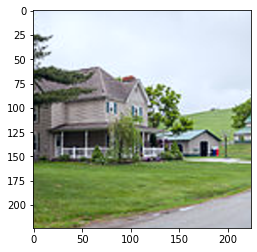

In [41]:
# process image (no fire)
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Green_Hills%2C_Pennsylvania_Mount_Road.jpg/220px-Green_Hills%2C_Pennsylvania_Mount_Road.jpg'
image = process_image(image_url)
top_prob, top_class = predict(image, model)
show_image(image)
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class)

The model is  99.74097609519958 % certain that the image has a predicted class of  0


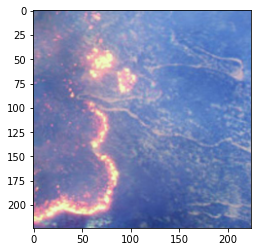

In [45]:
# process image (fire)
image_url = 'https://s3.amazonaws.com/content.satimagingcorp.com/media/cms_page_media/1481/WorldView-3%20Satellite%20Image%20of%20California%20Wildfires%20med.jpg'
image = process_image(image_url)
top_prob, top_class = predict(image, model)
show_image(image)
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class)

In [43]:
torch.save(model.classifier.state_dict(), 'fire_classifier')